In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 48.3MB/s 
     |████████████████████████████████| 901kB 45.1MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset"

In [ ]:
train = pd.read_csv(path + "/UIT-VSFC/VSFC_train.csv", index_col=False)
dev = pd.read_csv(path + "/UIT-VSFC/VSFC_dev.csv", index_col=False)
test = pd.read_csv(path + "/UIT-VSFC/VSFC_test.csv", index_col=False)

In [ ]:
%cd "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC/Topic"

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC/Topic


In [ ]:
X_train = train['Sents']
y_train = train['Topic'].values

X_dev = dev['Sents']
y_dev = dev['Topic'].values

X_test = test['Sents']
y_test = test['Topic'].values

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
num_labels = len(np.unique(y_test))

In [ ]:
path_model = ""

In [ ]:
phobert = RobertaForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = num_labels)
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_encodings = phobert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = phobert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = phobert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=50,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

phobert_trainer = Trainer(
    model=phobert,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
phobert_trainer.train()

Step,Training Loss
500,0.540800
1000,0.298200
1500,0.209600
2000,0.150400
2500,0.115600
3000,0.087100
3500,0.072500
4000,0.060000
4500,0.046700
5000,0.038800


TrainOutput(global_step=17900, training_loss=0.05219967165340113, metrics={'train_runtime': 5043.5387, 'train_samples_per_second': 113.274, 'train_steps_per_second': 3.549, 'total_flos': 1.8510304826976e+16, 'train_loss': 0.05219967165340113, 'epoch': 50.0})

In [ ]:
# Du doan 
y_pred_classify = phobert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Danh gia mo hinh
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))
print("accuracy: " + str(accuracy_score(y_true, y_pred)))

[[2155  104    3   28]
 [ 108  436    8   20]
 [   5    5  133    2]
 [  42   40    2   75]]
F1 - micro: 0.8840808591282375
F1 - macro: 0.7832220439754527
accuracy: 0.8840808591282375


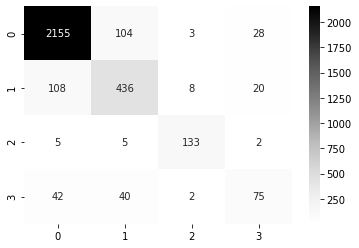

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})